In [1]:
# Package Imports

# File management
import os

# Data/numeric manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Modelling & Evaluation
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hyperopt import Trials, STATUS_OK, tpe, hp
from hyperopt.fmin import fmin

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [2]:
### Load Data

# Read in data
train_data = pd.read_csv(r'C:\Users\Angus\Documents\UTS MDSI\Advanced DSI\NBA Kaggle\adsi_g5_kaggle_nba\data\train.csv')
test_data = pd.read_csv(r'C:\Users\Angus\Documents\UTS MDSI\Advanced DSI\NBA Kaggle\adsi_g5_kaggle_nba\data\test.csv')

In [3]:
# Adjust data
train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')
test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

# train test val splits
X_data, X_test, y_data, y_test = train_test_split(train_data_x, train_data_target, test_size=0.2, random_state=42) # to numpy()
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [4]:
### Scale Positive Weight
# Source: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
from collections import Counter

# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 0.203


In [5]:
# Train RF Model

xgb = XGBClassifier(eval_metric='auc', scale_pos_weight=estimate)
xgb.fit(X_train, y_train)
print(xgb)

c:\users\angus\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.20329024676850763, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


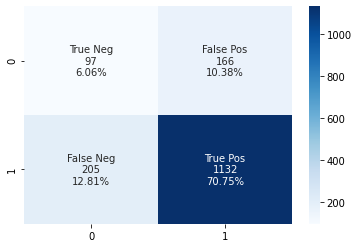

1298 out of 1600 or 81% of players are predicted to be 5+ Yrs
-----------
Recall: 0.8467
Accuracy: 0.7681
F1: 0.8592
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.675


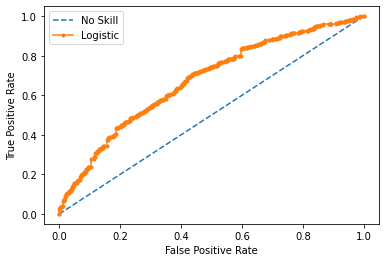

In [6]:
### Evaluations
y_test_pred = xgb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_test_pred)

# plot confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')
plt.show()

# print evaluation scores
print(f'{np.sum(y_test_pred)} out of {len(y_test_pred)} or {int(round(np.sum(y_test_pred)/len(y_test_pred)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'-----------\nRecall: {round(recall_score(y_test, y_test_pred), 4)}')
print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 4)}')
print(f'F1: {round(f1_score(y_test, y_test_pred), 4)}')
print(f'-----------')

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = xgb.predict_proba(X_test)[:,1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [7]:
### Remove low value columns

# Adjust data
train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')
test_data_x = test_data.drop(['Id_old', 'Id','DREB','FG%','PTS'], axis=1) # drop weak columns

# train test val splits
X_data, X_test, y_data, y_test = train_test_split(train_data_x, train_data_target, test_size=0.2, random_state=42) # to numpy()
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [8]:
# Train RF Model

xgb = XGBClassifier(eval_metric='auc', scale_pos_weight=estimate)
xgb.fit(X_train, y_train)
print(xgb)

c:\users\angus\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.20329024676850763, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


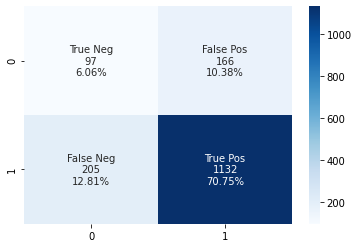

1298 out of 1600 or 81% of players are predicted to be 5+ Yrs
-----------
Recall: 0.8467
Accuracy: 0.7681
F1: 0.8592
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.675


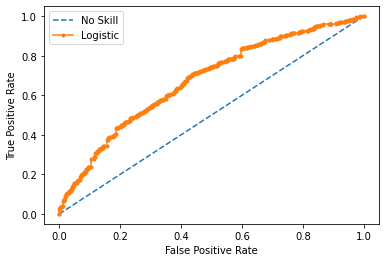

In [9]:
### Evaluations
y_test_pred = xgb.predict(X_test)
conf_mat = confusion_matrix(y_test, y_test_pred)

# plot confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')
plt.show()

# print evaluation scores
print(f'{np.sum(y_test_pred)} out of {len(y_test_pred)} or {int(round(np.sum(y_test_pred)/len(y_test_pred)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'-----------\nRecall: {round(recall_score(y_test, y_test_pred), 4)}')
print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 4)}')
print(f'F1: {round(f1_score(y_test, y_test_pred), 4)}')
print(f'-----------')

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = xgb.predict_proba(X_test)[:,1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [10]:
### Remove low value columns

# Adjust data
train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')
test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

# train test val splits
X_data, X_test, y_data, y_test = train_test_split(train_data_x, train_data_target, test_size=0.2, random_state=42) # to numpy()
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [11]:
### HP Optimize XGB

space = {
    'n_estimators':hp.choice('n_estimators',range(100,500)),
    #'eta': hp.quniform('eta', 0.1, 0.3, 0.2),
    'max_depth' : hp.choice('max_depth', np.arange(1, 20, dtype=int)),
    #'learning_rate' : hp.quniform('learning_rate', 0.1, 0.3, 0.2),
   # 'gamma' : hp.quniform('gamma',0.6, 0.8, 0.7),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.8, 0.7),
    'min_child_weight' : hp.quniform('min_child_weight', 5, 20, 12),
    #'subsample' : hp.quniform('subsample', 0.1, 0.3, 0.2),
    #'scale_pos_weight' : hp.quniform('scale_pos_weight',0.05, 0.3, 0.2)
}

In [12]:
def objective(space):
    
    xgboost = XGBClassifier(
        objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
        n_estimators = int(space['n_estimators']),
        #eta = space['eta'],
        #scale_pos_weight=space['scale_pos_weight'],
        max_depth = int(space['max_depth']),
        #learning_rate = space['learning_rate'],
        #gamma = space['gamma'],
        colsample_bytree = space['colsample_bytree'],
        min_child_weight = space['min_child_weight'],
        #subsample = space['subsample']
    )
    
    auc = cross_val_score(xgboost, X_train, y_train, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-auc, 'status': STATUS_OK }

In [13]:
best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=10
)

100%|███████████████████████████████████████████████| 10/10 [01:57<00:00, 11.70s/trial, best loss: 0.32899624461867827]


In [14]:
print(best)

{'colsample_bytree': 0.7, 'max_depth': 1, 'min_child_weight': 12.0, 'n_estimators': 49}


In [15]:
XGBhpt = XGBClassifier(
objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
n_estimators = 150, #best['n_estimators'],
eta = 0.2, #best['eta'],
scale_pos_weight= 0.1, #best['scale_pos_weight'],
max_depth = 10, #best['max_depth'],
learning_rate = 0.2, #best['learning_rate'],
gamma = 0.7, #best['gamma'],
colsample_bytree = best['colsample_bytree'],
min_child_weight = 12, #best['min_child_weight'],
subsample = 0.3,#best['subsample']
)

XGBhpt.fit(X_train, y_train)
print(XGBhpt)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.2,
              eval_metric='logloss', gamma=0.7, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=12, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1, subsample=0.3,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


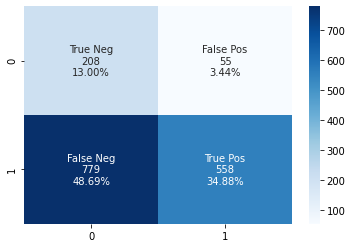

613 out of 1600 or 38% of players are predicted to be 5+ Yrs
-----------
Recall: 0.4174
Precision: 0.9103
Accuracy: 0.4788
F1: 0.5723
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.681


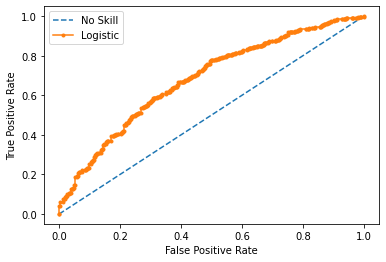

In [20]:
### Evaluations
y_test_pred = XGBhpt.predict(X_test)
conf_mat = confusion_matrix(y_test, y_test_pred)

# plot confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')
plt.show()

# print evaluation scores
print(f'{np.sum(y_test_pred)} out of {len(y_test_pred)} or {int(round(np.sum(y_test_pred)/len(y_test_pred)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'-----------\nRecall: {round(recall_score(y_test, y_test_pred), 4)}')
print(f'Precision: {round(precision_score(y_test, y_test_pred), 4)}')
print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 4)}')
print(f'F1: {round(f1_score(y_test, y_test_pred), 4)}')
print(f'-----------')

ns_probs = [0 for _ in range(len(y_test))]
lr_probs = XGBhpt.predict_proba(X_test)[:,1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (roc_auc_score(y_test, XGBhpt.predict_proba(X_test)[:,1])))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [17]:
roc_auc_score(y_val, XGBhpt.predict_proba(X_val)[:,1])

0.6915807913790817

In [89]:
# Check against test set
y_pred = XGBhpt.predict(test_data_x)

# Submission output
preddf = pd.DataFrame(y_pred, columns=['TARGET_5Yrs'])
submit = pd.DataFrame(test_data['Id']).merge(preddf, right_index=True, left_index=True, how='left')
submit.index = submit['Id']
submit = submit.drop(columns=['Id'])

submit.head()

,TARGET_5Yrs
Id,
0,0
1,0
2,1
3,1
4,0


In [90]:
# Print out
submit.to_csv(r'C:\Users\Angus\Documents\UTS MDSI\Advanced DSI\NBA Kaggle\ANSubmitXGBHP6.csv')

In [18]:
# Save model
from joblib import dump  

dump(XGBhpt, r'C:\Users\Angus\Documents\UTS MDSI\Advanced DSI\NBA Kaggle\adsi_g5_kaggle_nba\models\AN_HP_XGB_SMOTE_0.1.joblib')

['C:\\Users\\Angus\\Documents\\UTS MDSI\\Advanced DSI\\NBA Kaggle\\adsi_g5_kaggle_nba\\models\\AN_HP_XGB_SMOTE_0.1.joblib']